# Dynamic Rupture using SBP-FDM Method

## Mitchell Williams & Kenneth Duru

This notebook is a 1D dynamic rupture notebook that will be extended into 2D

In [1]:
# Import necessary routines

import numpy as np
import matplotlib.pyplot as plt
import time_integrator
import rate
import utils
import timeit

plt.switch_backend("nbagg")           # plots within this notebook

In [2]:
# Parameter cell
# All user defined parameters can be entered in this window. 

t = 0.0          # initial time
tend = 4.0      # final time
cfl = 0.5   # CFL number

L = 15.0         # length of the domain (km)
nx = 301        # grid points in x       
cs = 3.464       # velocity (km/s) (can be an array)                                                                                                             
rho = 2.6702     # density [g/cm^3]

iplot = 5       # snapshot frequency
order = 6        # order of accuracy

fric_law = 'SW' # 'SW = slip weakening', 'RS' = rate and state  


In [3]:
# Initialization cell 
# Do not alter
# spacing and material parameters

ny = nx          # grid points in y                                                                                                                       
dx = L/(nx-1)    # grid increment in x
dy = dx         # grid increment in y

rho_l = rho     # density [g/cm^3]
mu_l = rho_l*cs**2   # shear modulus [GPa]
Zs_l = rho_l*cs      # shear impedance 

rho_r = rho     # density [g/cm^3]
mu_r = rho_r*cs**2   # shear modulus [GPa]
Zs_r = rho_r*cs      # shear impedance 

#Initialize the domains L R
y_l = np.zeros((nx, 1))
y_r = np.zeros((nx, 1))

# Initial particle velocity perturbation and discretize the domain L R 
for j in range(0, nx):
    y_l[j, :] = -L + j*dx                                             # discrete domain
    y_r[j, :] =  0 + j*dx                                             # discrete domain

# Time stepping parameters
t=0   # initial time
dt = (cfl/cs)*dx                  # Time step
nt = int(round(tend/dt))          # number of time steps

# Initialize: particle velocity (v); and shear stress (s); and returns L
v_l = np.zeros((nx,1))
s_l = np.zeros((nx,1))
U_l = np.zeros((nx,1))
V_l = np.zeros((nx,1))
U_t_l = np.zeros((nx,1))
V_t_l = np.zeros((nx,1))
U_x_l = np.zeros((nx,1))
V_x_l = np.zeros((nx,1))

# Initialize: particle velocity (v); and shear stress (s); and returns R
v_r = np.zeros((nx,1))
s_r = np.zeros((nx,1))
U_r = np.zeros((nx,1))
V_r = np.zeros((nx,1))
U_t_r = np.zeros((nx,1))
V_t_r = np.zeros((nx,1))
U_x_r = np.zeros((nx,1))
V_x_r = np.zeros((nx,1))

# Initialize slip parameters
slip = np.zeros((1, 1))
psi = np.zeros((1, 1))

# Initial particle velocity perturbation and discretize the domain
for j in range(0, nx):
    y_l[j, :] = -L + j*dx                                             # discrete domain
    y_r[j, :] =  0 + j*dx    
        
# Boundary condition reflection coefficients  L
r0_l = 1                            # r=0:absorbing, r=1:free-surface, r=-1: clamped 
r1_l = 1                            # r=0:absorbing, r=1:free-surface, r=-1: clamped
# penalty parameters L
tau_11_l = 1 
tau_12_l = 1
tau_21_l = 1 
tau_22_l = 1

# Boundary condition reflection coefficients  R
r0_r = 1                            # r=0:absorbing, r=1:free-surface, r=-1: clamped 
r1_r = 1                            # r=0:absorbing, r=1:free-surface, r=-1: clamped
# penalty parameters R
tau_11_r = 1 
tau_12_r = 1
tau_21_r = 1 
tau_22_r = 1


<IPython.core.display.Javascript object>


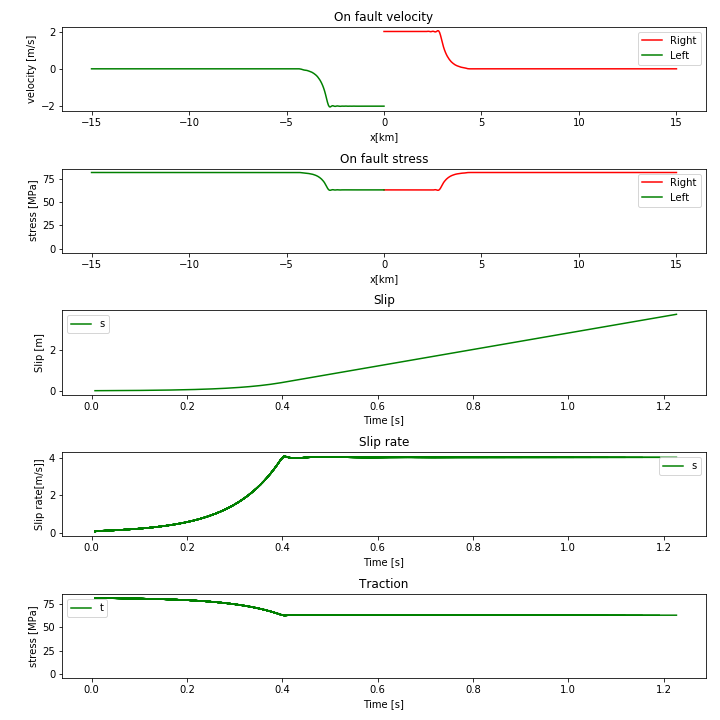

In [ ]:
# Calculations and plottings for on fault slip velocity and stress

if fric_law not in ('SW', 'RS'):
    # Choose friction law: fric_law
    # We use linear (LN: T = alpha*v, alpha >=0)
    # Slip-weakening (SW)
    # Rate-and-state friction law (RS)
    
     print('friction law not implemented. choose fric_law = SW or fric_law = RS')
     exit(-1)
    
if fric_law  in ('SW'):
     alpha = 1e1000000              # initial friction coefficient
     slip[:,:] = 0.0                        # initial slip (in m)
     Tau_0 = 81.24+1.0*0.36         # initial load (81.24 in MPa), slight increase will unlock the fault
     alp_s = 0.677                           # stastic friction
     alp_d = 0.525                           # dynamic friction
     D_c = 0.40                              # critical slip
     sigma_n = 120.0    # normal stress 
        
     # These are not needed for the slip weakening case   
     psi[:,:] = 0.0                         # initial condition for the state variable in friction law
     L0 = 0.0                               # state evolution distance
     f0 = 0.0                               # referance friction coeff
     a = 0.0                                # direct effect 
     b = 0.0                                # evolution parameter 
     V0 = 0.0                               # reference slip rate
    
if fric_law  in ('RS'):
     alpha = 1e1000000                      # initial friction coefficient                                                                                   
     slip[:,:] = 0.0                        # initial slip (in m)                                                                                                                             
     Tau_0 = 81.24+0.1*0.36                 # initial load (81.24 in MPa), slight increase will unlock the fault   
     psi[:,:] = 0.4367                      # initial condition for the state variable in friction law
     L0 = 0.02                              # state evolution distance
     f0 = 0.6                               # referance friction coeff
     a = 0.008                              # direct effect 
     b = 0.012                              # evolution parameter 
     V0 = 1.0e-6                            # reference slip rate
     sigma_n = 120.0                        # background normal stress 

     # These are not needed for the rate and state case   
     alp_s = 0.0                             # stastic friction
     alp_d = 0.0                             # dynamic friction
     D_c = 0.0                               # critical slip
    
friction_parameters = [fric_law,alpha,slip,Tau_0,psi,L0,f0,a,b,V0,sigma_n,alp_s,alp_d,D_c]    
    
# Initial variables    
Vd = [0]               # initial velocity
Sd = [Tau_0]           # background stress
T = [t]                # time
Slip = [0]    

# setting slip, slip rate, traction, and time vectors to empty sets
traction_vector = []
slip_vector = []
time_vector = []
sliprate_vector = []

# Initialize animated plot for velocity and stress
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(5,1,1)
line1 = ax1.plot(y_l, v_l, 'r', y_r, v_r, 'g')
plt.title('On fault velocity')
plt.xlabel('x[km]')
plt.ylabel('velocity [m/s]')

ax2 = fig1.add_subplot(5,1,2)
line2 = ax2.plot(y_l, s_l, 'r', y_r, s_r, 'g')
plt.title('On fault stress')
plt.xlabel('x[km]')
plt.ylabel('stress [MPa]')

ax3 = fig1.add_subplot(5,1,3)
line3 = ax3.plot(0,0,'g')
plt.title('Slip')
plt.xlabel('Time [s]')
plt.ylabel('Slip [m]')

ax4 = fig1.add_subplot(5,1,4)
line4 = ax4.plot(0,0,'g')
plt.title('Slip rate')
plt.xlabel('Time [s]')
plt.ylabel('Slip rate[m/s]]')

ax5 = fig1.add_subplot(5,1,5)
line5 = ax5.plot(0,0,'g')
plt.title('Traction')
plt.xlabel('Time [s]')
plt.ylabel('stress [MPa]')

plt.tight_layout()
plt.ion()
plt.show()

# Loop through time and evolve the wave-fields using ADER time-stepping scheme of N+1 order of accuracy
start = timeit.default_timer()

n = 0                             # counter
for t in utils.drange (0.0, tend+dt,dt):
    n = n+1
    
    # compute numerical solution 
    time_integrator.elastic_RK4(v_l, s_l, v_l, s_l, rho_l, mu_l, nx, dx, order, y_l, t, dt, r0_l, r1_l,  tau_11_l,\
                    tau_21_l, tau_12_l, tau_22_l,v_r, s_r, v_r, s_r, rho_r, mu_r, nx, dx, order,\
                                y_r, t, dt, r0_r, r1_r,  tau_11_r, tau_21_r, tau_12_r, tau_22_r,\
                               slip, psi, slip, psi, alpha, Tau_0, fric_law, 0)
    
    # appending slip, slip rate, traction, and time vector through each time step.
    traction_vector.append(Tau_0+s_l[-1,0])
    slip_vector.append(slip[0,0])
    time_vector.append(n*dt)
    sliprate_vector.append(np.abs(v_r[0,0]-v_l[-1,0]))
    
    # Updating plots
    if n % iplot == 0: 
        for l in line1:
            l.remove()
            del l               
        for l in line2:
            l.remove()
            del l
        for l in line3:
            l.remove()
            del l

        # Display lines
        line1 = ax1.plot(y_r, v_r, 'r',y_l, v_l, 'g')
        ax1.legend(iter(line1),('Right', 'Left'))
        line2 = ax2.plot(y_r, s_r+Tau_0, 'r',y_l, s_l+Tau_0, 'g')
        ax2.legend(iter(line2),('Right', 'Left'))
        line3 = ax3.plot(time_vector,slip_vector,'g')
        ax3.legend(iter(line3),('slip'))
        line4 = ax4.plot(time_vector,sliprate_vector,'g')
        ax4.legend(iter(line4),('slip rate'))
        line5 = ax5.plot(time_vector,traction_vector,'g')
        ax5.legend(iter(line5),('traction'))
        plt.gcf().canvas.draw()
                   
    
plt.ioff()
plt.show()
# Simulation end time
stop = timeit.default_timer()
print('total simulation time = ', stop - start)                   # print the time required for simulation
print('spatial order  of accuracy = ', order)                     # print the polynomial degree used
print('number of grid points = ', nx)                             # print the degree of freedom